In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from preprocessing import *
from image_utils import *
from bbox_utils import *

In [2]:
feature_maps_sizes = [112, 56, 28, 14, 7]

In [3]:
archive_path = '../archive'
images_path = archive_path + '/images'

train_labels = archive_path + '/labels_train.csv'
test_labels = archive_path + '/labels_val.csv'
val_labels = archive_path + '/labels_trainval.csv'

In [4]:
INPUT_SIZE = (224,224)
ORG_IMG_SIZE = (300,480)

In [5]:
train_df = preprocess_data(train_labels, ORG_IMG_SIZE, INPUT_SIZE)
val_df = preprocess_data(val_labels, ORG_IMG_SIZE, INPUT_SIZE)
test_df = preprocess_data(test_labels, ORG_IMG_SIZE, INPUT_SIZE)

### Create tfrecords

In [6]:
from preprocessing import create_tfrecord
train_output = './tfrecords/train.tfrecords'
val_output = './tfrecords/val.tfrecords'
test_output = './tfrecords/test.tfrecords'

create_tfrecord(images_path, train_df.index, train_df['label'], train_output)
create_tfrecord(images_path, val_df.index, val_df['label'], val_output)
create_tfrecord(images_path, test_df.index, test_df['label'], test_output)



### Anchor boxes

In [7]:
fm_sizes = [112, 56, 28, 14, 7, 1]

generate_bboxes(fm_sizes)

array([[4.46428571e-03, 4.46428571e-03, 2.47297554e+01, 2.47297554e+01],
       [4.46428571e-03, 4.46428571e-03, 2.46200000e+01, 2.46200000e+01],
       [4.46428571e-03, 4.46428571e-03, 3.48179379e+01, 1.74089690e+01],
       ...,
       [5.00000000e-01, 5.00000000e-01, 3.46410162e-01, 1.15470054e-01],
       [5.00000000e-01, 5.00000000e-01, 1.41421356e-01, 2.82842712e-01],
       [5.00000000e-01, 5.00000000e-01, 1.15412304e-01, 3.46583497e-01]])

In [8]:
def convert_format(out,format):
  if format == 'x1y1x2y2':
    return tf.stack([out[...,0]-out[...,2]/2.0,
    out[...,1]-out[...,3]/2.0,
    out[...,0]+out[...,2]/2.0,
    out[...,1]+out[...,3]/2.0]
    ,axis=-1)

  elif format == 'xywh':
    return tf.stack([(out[...,0]+out[...,2])/2.0,
    (out[...,1]+out[...,3])/2.0,
    out[...,2]-out[...,0],
    out[...,3]-out[...,1],
    out[...,4]],axis=-1)

In [9]:
hImage, wImage = 224, 224

In [10]:
def convert_scale(matrix,scale):
  if scale == 'abs':
    return tf.stack([matrix[:,0]*wImage,
    matrix[:,1]*hImage,
    matrix[:,2]*wImage,
    matrix[:,3]*hImage],axis=-1)

  elif scale == 'rel':
    return tf.stack([matrix[:,0]/wImage,
    matrix[:,1]/hImage,
    matrix[:,2]/wImage,
    matrix[:,3]/hImage],axis=-1)

In [11]:

def normalised_ground_truth(matched_boxes,feature_box,return_format):
  matched_boxes = tf.cast(matched_boxes,dtype=tf.float32)
  feature_box = tf.cast(feature_box,dtype=tf.float32)
  if return_format == "encode":
    return tf.stack([(matched_boxes[:,0] - feature_box[:, 0]) / (feature_box[:, 2]),
                   (matched_boxes[:,1] - feature_box[:, 1]) / (feature_box[:, 3]),
        tf.math.log(matched_boxes[:,2] / feature_box[:, 2]),
        tf.math.log(matched_boxes[:,3] / feature_box[:, 3])],
        axis=-1) / [0.1, 0.1, 0.2, 0.2]

  elif return_format == "decode":
    matched_boxes *= [0.1, 0.1, 0.2, 0.2]
    return tf.stack([matched_boxes[:,0] * feature_box[:, 2] + (feature_box[:, 0]),
                    matched_boxes[:,1] * feature_box[:, 3] + (feature_box[:, 1]),
          tf.math.exp(matched_boxes[:,2]) * feature_box[:, 2],
          tf.math.exp(matched_boxes[:,3]) * feature_box[:, 3]],
          axis=-1)

In [12]:

def imshow(image):
    plt.figure(figsize=(8, 10))
    plt.imshow(image)

In [13]:
def show_img(img,label):
  img = cv2.imread(img)
  color = (255,0,0)
  img = cv2.resize(img,(hImage,wImage))
  for i,val in enumerate(label):
    start = tuple((np.array(label[i][:2])).astype('int'))
    end = tuple((np.array(label[i][2:4])).astype('int'))
    cv2.rectangle(img,start,end,color,1)
  imshow(img)

In [14]:
def pre_process_img(img,feature_box_conv,matched):
  img = cv2.imread(img)
  img = cv2.resize(img, (hImage,wImage), interpolation = cv2.INTER_AREA)
  color = (255,0,0)
  matched_idx = np.where(matched)
  for i in (matched_idx):
    for j in i:
      start = feature_box_conv[j,:2]
      end = feature_box_conv[j,2:4]
      start = tuple((start))
      end = tuple((end))
      cv2.rectangle(img,start,end,color,2)
  plt.title('Matched Boxes')
  imshow(img)  

In [15]:
nClasses = 5

In [16]:
i = 1234
images,labels = train_df.iloc[i].name,train_df.iloc[i]['label']
labels

[[62.07, 103.04, 75.6, 119.47, 1.0],
 [74.67, 103.79, 84.93, 116.48, 1.0],
 [80.73, 100.8, 88.2, 112.75, 1.0],
 [87.73, 103.04, 96.13, 112.75, 1.0],
 [106.87, 103.79, 114.8, 114.24, 1.0],
 [118.07, 103.04, 126.93, 114.99, 1.0],
 [144.67, 97.81, 209.53, 159.79, 1.0]]

In [17]:
images

'1478020921212776782.jpg'

In [18]:
df = pd.read_csv(train_labels)
df = df[df['frame'] == images]
df

,frame,xmin,xmax,ymin,ymax,class_id
9318,1478020921212776782.jpg,133,162,138,160,1
9319,1478020921212776782.jpg,160,182,139,156,1
9320,1478020921212776782.jpg,173,189,135,151,1
9321,1478020921212776782.jpg,188,206,138,151,1
9322,1478020921212776782.jpg,229,246,139,153,1
9323,1478020921212776782.jpg,253,272,138,154,1
9324,1478020921212776782.jpg,310,449,131,214,1


In [19]:

image_path=os.path.join(images_path,images)

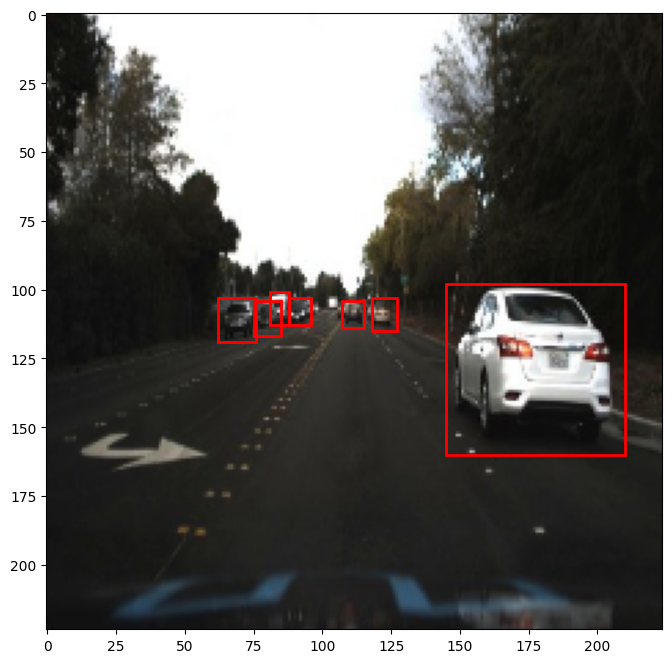

In [20]:
image = cv2.imread(image_path)
img = cv2.resize(image, dsize=(224, 224))
plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for label in labels:
    xmin, ymin, xmax, ymax, _ = label 
    width = xmax - xmin
    height = ymax - ymin
    plt.gca().add_patch(plt.Rectangle((int(np.round(xmin)), int(np.round(ymin))), int(np.round(width)), int(np.round(height)), color = 'red', fill = False, linewidth = 2))
plt.show()

(300, 480, 3)
(7, 6)


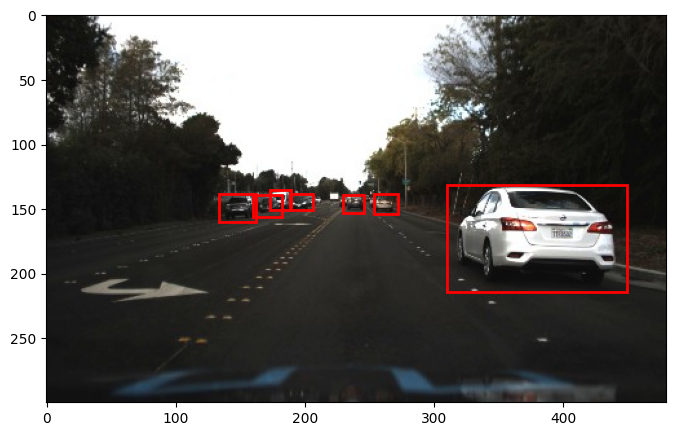

In [21]:
base_path = '../archive/images/'
image_name = '1478020921212776782.jpg'
image = cv2.imread(base_path + image_name)
print(image.shape)
plt.figure(figsize = (8,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

labels = df[df['frame'] == image_name]
print(labels.shape)
for index,row in labels.iterrows():
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color = 'red', fill = False, linewidth = 2))
plt.show()

1478020921212776782.jpg
tf.Tensor(0, shape=(), dtype=int64)


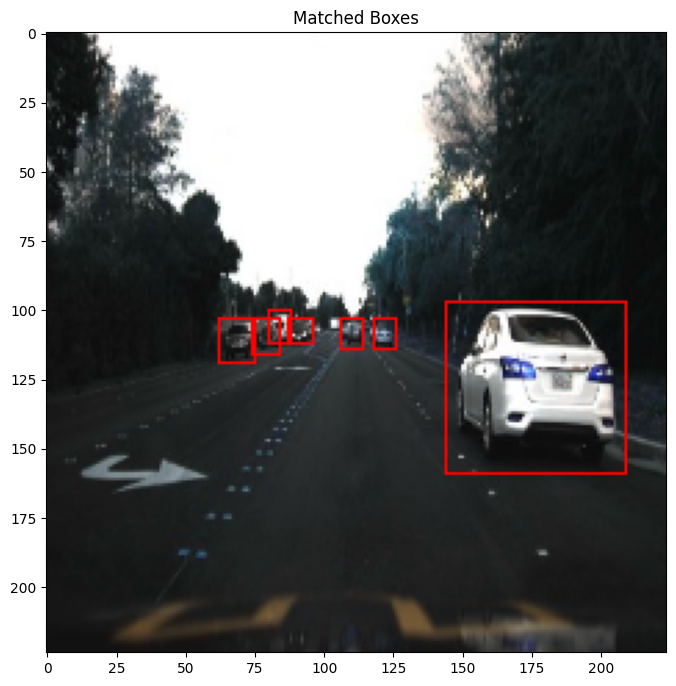

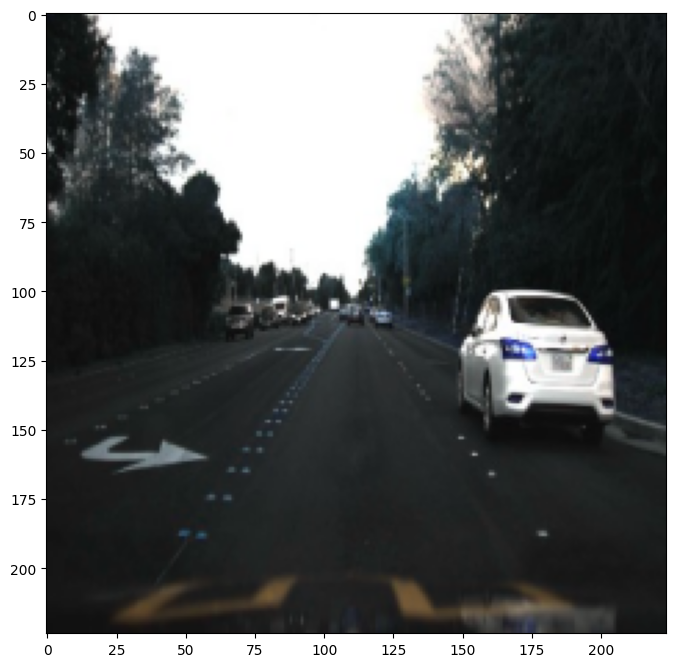

In [22]:
#Matched Boxes
def create_data(data):
  i = 1234
  images,labels = data.iloc[i].name,data.iloc[i]['label']
  # labels  x1y1x2y2
  print(images)
  root=images_path

  images=os.path.join(root,images)
      
  #GT boxes creation
  img = images
  label = labels
  show_img(img,label)
  feature_box = generate_bboxes(fm_sizes)
  feature_box = convert_scale(feature_box,'abs')
  feature_box_conv = convert_format(feature_box,'x1y1x2y2')
  iou_matrix = iou(feature_box_conv,np.array(label)[:,:4])
  gt_box,matched = df_match(convert_format(np.array(label),'xywh'),iou_matrix)
  # gt_box xywh
  print(tf.math.count_nonzero(matched))
  pre_process_img(img,convert_format(feature_box,'x1y1x2y2'),matched)
  boxes=gt_box[:,:4]
  classes = gt_box[:,4]
  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')  
  normalised_gtbox = normalised_ground_truth(normalised_gtbox,feature_box,'decode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  return df_box

df_box = create_data(train_df)